In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# 1. Gather all image paths and labels
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/'

train_pneumonia_dir = os.path.join(base_dir, 'train/PNEUMONIA')
train_normal_dir = os.path.join(base_dir, 'train/NORMAL')
test_pneumonia_dir = os.path.join(base_dir, 'test/PNEUMONIA')
test_normal_dir = os.path.join(base_dir, 'test/NORMAL')
val_pneumonia_dir = os.path.join(base_dir, 'val/PNEUMONIA')
val_normal_dir = os.path.join(base_dir, 'val/NORMAL')

all_images = []
all_labels = []

for img_file in os.listdir(train_pneumonia_dir):
    all_images.append(os.path.join(train_pneumonia_dir, img_file))
    all_labels.append('PNEUMONIA')
for img_file in os.listdir(train_normal_dir):
    all_images.append(os.path.join(train_normal_dir, img_file))
    all_labels.append('NORMAL')
for img_file in os.listdir(test_pneumonia_dir):
    all_images.append(os.path.join(test_pneumonia_dir, img_file))
    all_labels.append('PNEUMONIA')
for img_file in os.listdir(test_normal_dir):
    all_images.append(os.path.join(test_normal_dir, img_file))
    all_labels.append('NORMAL')
for img_file in os.listdir(val_pneumonia_dir):
    all_images.append(os.path.join(val_pneumonia_dir, img_file))
    all_labels.append('PNEUMONIA')
for img_file in os.listdir(val_normal_dir):
    all_images.append(os.path.join(val_normal_dir, img_file))
    all_labels.append('NORMAL')

all_images = np.array(all_images)
all_labels = np.array(all_labels)


In [3]:
# 75% test
X_temp, X_test, y_temp, y_test = train_test_split(
    all_images, all_labels, test_size=0.75, random_state=42, stratify=all_labels)

# 5% val (of total, so 0.05/0.25 = 0.20 of what's left)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.20, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 1171, Val: 293, Test: 4392


In [4]:
# 3. Load and preprocess images
def load_and_preprocess_images(image_paths, target_size=(150, 150)):
    images = []
    for img_path in tqdm(image_paths):
        try:
            img = cv2.imread(img_path)
            img = cv2.resize(img, target_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return np.array(images)

print("Loading training images...")
X_train_images = load_and_preprocess_images(X_train)
print("Loading validation images...")
X_val_images = load_and_preprocess_images(X_val)
print("Loading test images...")
X_test_images = load_and_preprocess_images(X_test)

def flatten_and_normalize(images):
    n_samples = images.shape[0]
    h, w, c = images.shape[1], images.shape[2], images.shape[3]
    X_flat = images.reshape(n_samples, h*w*c).astype('float32') / 255.0
    return X_flat

X_train_flat = flatten_and_normalize(X_train_images)
X_val_flat = flatten_and_normalize(X_val_images)
X_test_flat = flatten_and_normalize(X_test_images)

Loading training images...


100%|██████████| 1171/1171 [00:33<00:00, 35.45it/s]


Loading validation images...


100%|██████████| 293/293 [00:08<00:00, 34.20it/s]


Loading test images...


100%|██████████| 4392/4392 [01:57<00:00, 37.37it/s]


In [5]:
# 4. PCA
n_components = 200  # Tune as needed
print("Fitting PCA...")
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca = pca.transform(X_val_flat)
X_test_pca = pca.transform(X_test_flat)
print(f"PCA reduced to {n_components} components.")

Fitting PCA...
PCA reduced to 200 components.


In [6]:
# 5. Encode labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)
print(f"Class mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")


Class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}


In [7]:
# 6. Train XGBoost
xgb_model = XGBClassifier(
    objective='binary:logistic',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    verbosity=1
)

Training XGBoost with PCA features...
[0]	validation_0-logloss:0.56757
[1]	validation_0-logloss:0.52841
[2]	validation_0-logloss:0.49196
[3]	validation_0-logloss:0.46173


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-logloss:0.43853
[5]	validation_0-logloss:0.42018
[6]	validation_0-logloss:0.40263
[7]	validation_0-logloss:0.39501
[8]	validation_0-logloss:0.38291
[9]	validation_0-logloss:0.37451
[10]	validation_0-logloss:0.36631
[11]	validation_0-logloss:0.35704
[12]	validation_0-logloss:0.34574
[13]	validation_0-logloss:0.34142
[14]	validation_0-logloss:0.33692
[15]	validation_0-logloss:0.33662
[16]	validation_0-logloss:0.32981
[17]	validation_0-logloss:0.32291
[18]	validation_0-logloss:0.31684
[19]	validation_0-logloss:0.31292
[20]	validation_0-logloss:0.30651
[21]	validation_0-logloss:0.30662
[22]	validation_0-logloss:0.30658
[23]	validation_0-logloss:0.30417
[24]	validation_0-logloss:0.30372
[25]	validation_0-logloss:0.30283
[26]	validation_0-logloss:0.29798
[27]	validation_0-logloss:0.29361
[28]	validation_0-logloss:0.29353
[29]	validation_0-logloss:0.29047
[30]	validation_0-logloss:0.28692
[31]	validation_0-logloss:0.28370
[32]	validation_0-logloss:0.28109
[33]	validation_0-lo

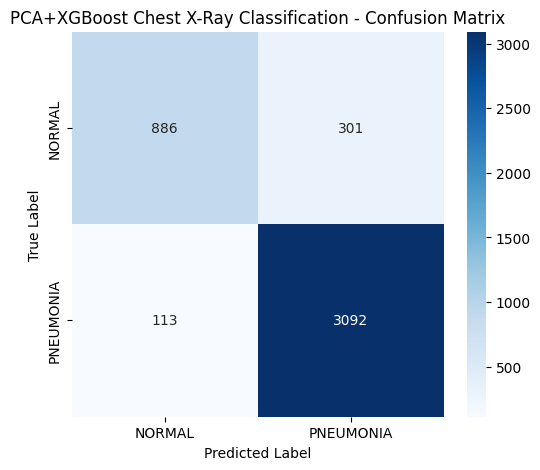

In [8]:
print("Training XGBoost with PCA features...")
xgb_model.fit(
    X_train_pca, y_train_enc,
    eval_set=[(X_val_pca, y_val_enc)],
    early_stopping_rounds=20,
    verbose=True
)


# 7. Evaluation
print("Evaluating...")
y_pred_train = xgb_model.predict(X_train_pca)
y_pred_val = xgb_model.predict(X_val_pca)
y_pred_test = xgb_model.predict(X_test_pca)

train_acc = accuracy_score(y_train_enc, y_pred_train)
val_acc = accuracy_score(y_val_enc, y_pred_val)
test_acc = accuracy_score(y_test_enc, y_pred_test)

print("\nXGBOOST RESULTS")
print(f"Training Accuracy: {train_acc:.4f} ({train_acc:.2%})")
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc:.2%})")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc:.2%})")

print("\nClassification Report (Test):")
print(classification_report(y_test_enc, y_pred_test, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test_enc, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('PCA+XGBoost Chest X-Ray Classification - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()